In [1]:
#import some packages to use for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_json('logins.json') #read the data into a pandas dataframe

In [3]:
data["logtimes"] = pd.to_datetime(data.loc[:,0]) #convert strings to datetimes

In [4]:
#adding some columns to the dataframe for convenience later
data["day_of_week"] = [lt.dayofweek for lt in data.logtimes] #starts at 0 for Monday through 6 for Sunday
data["hour_of_day"] = [lt.hour for lt in data.logtimes] #0 through 23
data.head()


,0,logtimes,day_of_week,hour_of_day
0,2012-03-01T00:05:55+00:00,2012-03-01 00:05:55,3,0
1,2012-03-01T00:06:23+00:00,2012-03-01 00:06:23,3,0
2,2012-03-01T00:06:52+00:00,2012-03-01 00:06:52,3,0
3,2012-03-01T00:11:23+00:00,2012-03-01 00:11:23,3,0
4,2012-03-01T00:12:47+00:00,2012-03-01 00:12:47,3,0


In [5]:
#figuring out the total number of hours in the data range
td = data.logtimes[len(data.logtimes)-1] - data.logtimes[0]
nhours = round(td.total_seconds()/3600)
print(nhours)

1464


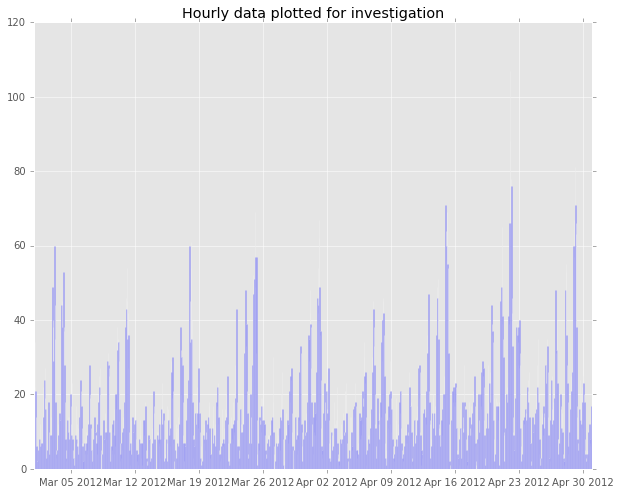

In [6]:
#plotting up a histogram of hourly login frequency
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
binned = ax.hist(np.array(data.logtimes), bins=nhours, color='b')

ax.set_title('Hourly data plotted for investigation')
#the data have some obvious periodicity, likely on a weekly and daily basis, but we'll explore further...

In [7]:
#creating some arrays for plotting and fitting
nlogins = np.array(binned[0]) #number of logins per hour
binleft = binned[1][:-1]
binsize = (binleft[1] - binleft[0])/2
hour_after_start = (binleft - binleft[0])*24 #bin center for logins histogram

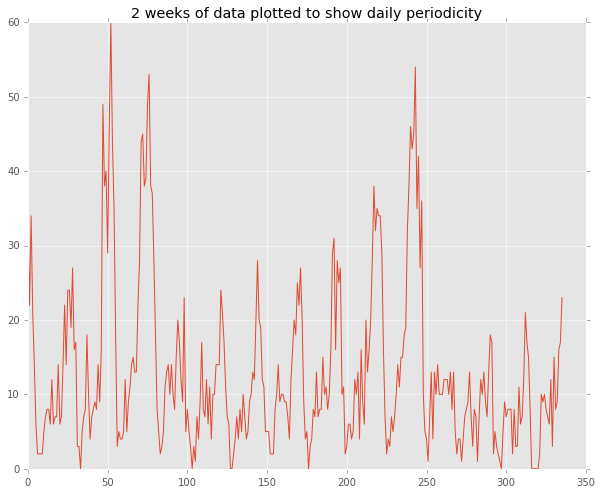

In [8]:
ndays = 14 #let's plot 2 weeks worth of data for a zoomed in look
start = 0
end = ndays*24
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(hour_after_start[start:end], nlogins[start:end])
ax.set_title('2 weeks of data plotted to show daily periodicity')
#indeed looks like strong daily periodicity

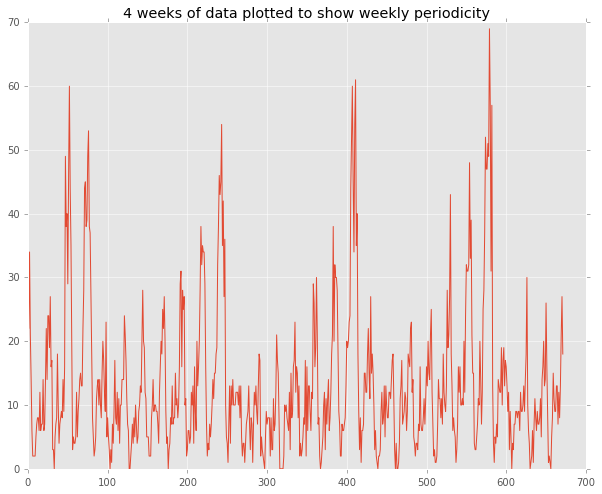

In [9]:
ndays = 28 #let's plot 4 weeks worth of data for a look at the weekly periodicity
start = 0
end = ndays*24
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(hour_after_start[start:end], nlogins[start:end])
ax.set_title('4 weeks of data plotted to show weekly periodicity')
#here we can clearly see the weekly periodicity

In [10]:
#let's try a Fourier transform to get out the strongest periodicities in the data.
import scipy.fftpack as fftpack 
pi = np.pi
yhat = fftpack.rfft(nlogins)
yhat[0] = 0
yplot = np.copy(yhat) #saving this for plotting later
#let's figure out which are the 3 strongest frequency signals in the hourly data
idx1 = (yhat**2).argmax()
yhat[idx1] = 0
idx2 = (yhat**2).argmax()
yhat[idx2] = 0
idx3 = (yhat**2).argmax()

freqs = fftpack.rfftfreq(nhours, d = (hour_after_start[1]-hour_after_start[0]))
#these are the 3 strongest periods detected in the data (in hours)
Period1 = 1/freqs[idx1]
Period2 = 1/freqs[idx2]
Period3 = 1/freqs[idx3]


periods = 1/freqs
print(Period1, Period2, Period3) #shows the strongest signals are on 24 hour, 7 day, and 12 hour periodicity

23.998242259 162.654753089 11.9991211295


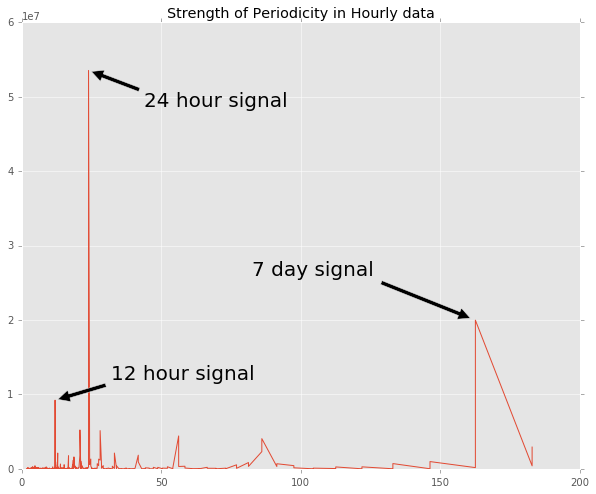

In [11]:
#here we'll plot up the strength of the frequencies to show those detected
minperiod = 0
maxperiod = 200 #not very interested in frequencies over 1 week
good = (periods < maxperiod).nonzero()[0]
plotp = periods[good]
yp = yplot[good]**2
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(plotp, yp) #here's what that looks like in a plot
ax.set_title('Strength of Periodicity in Hourly data')
ax.annotate('24 hour signal', xy=(periods[idx1], yplot[idx1]**2), xytext=(periods[idx1]+20, (yplot[idx1]**2)/1.1),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20,
            )
ax.annotate('7 day signal', xy=(periods[idx2], yplot[idx2]**2), xytext=(periods[idx2]-80, (yplot[idx2]**2)*1.3),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20,
            )
ax.annotate('12 hour signal', xy=(periods[idx3], yplot[idx3]**2), xytext=(periods[idx3]+20, (yplot[idx3]**2)*1.3),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20,
            )

[13.296919178618726, 0.26181856318316493, 0.0, 15.332650273224044, 13.296919178618726, 0.038628968338499742, 0.0, 15.332650273224044, 13.296919178618726, 0.52363712636632986, 0.0, 15.332650273224044]
10.0458596843 0.26201816266 -11.088039233 7977293.97423 1.55061403103 0.0365367210673 -0.0102095653215 788845773.071 5.4486843144 0.523807231212 0.711466284596 -796823051.855


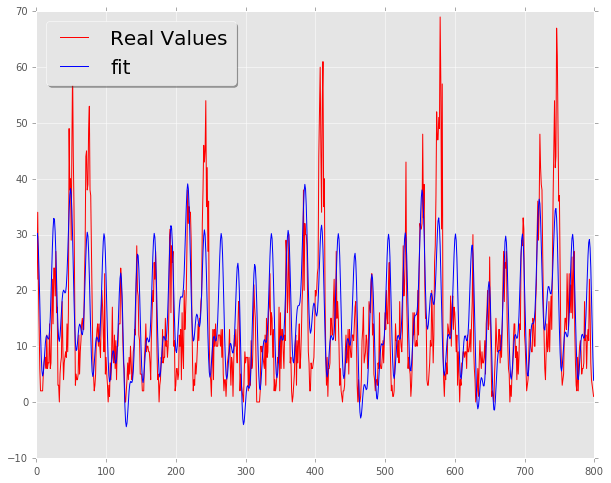

In [12]:
#now we'll try fitting the data with a 3 component sine curve using scipy optimize
import scipy.optimize as optimize

#defining our 3 component sine curve
def mysine(x, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12):
    return (a1 * np.sin(a2 * x + a3) + a4) + ((a5 * np.sin(a6 * x + a7))**5 + a8) + ((a9 * np.sin(a10 * x + a11)) + a12)

#initial guesses to feed to the optimizer
amplitude1 = np.std(nlogins)
frequency1 = 2*pi*freqs[idx1]
systematic1 = np.mean(nlogins)
amplitude2 = np.std(nlogins)
frequency2 = 2*pi*freqs[idx2]
systematic2 = np.mean(nlogins)
amplitude3 = np.std(nlogins)
frequency3 = 2*pi*freqs[idx3]
systematic3 = np.mean(nlogins)

guess = [amplitude1, frequency1, 0., systematic1, amplitude2, frequency2, 0., systematic2, amplitude3, frequency3, 0., systematic3]

print(guess)
(amplitude1, frequency1, phase1, systematic1, amplitude2, frequency2, phase2, systematic2, amplitude3,
             frequency3, phase3, systematic3), pcov = optimize.curve_fit(
             mysine, hour_after_start, nlogins, guess)


print(amplitude1, frequency1, phase1, systematic1, amplitude2, frequency2, phase2, systematic2, 
      amplitude3, frequency3, phase3, systematic3)

#calculating the fitted data
xx = hour_after_start
yy = mysine(xx, amplitude1, frequency1, phase1, systematic1, amplitude2, frequency2, phase2, systematic2, 
            amplitude3, frequency3, phase3, systematic3)

# plot the real data versus the fit
endind = 800
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(hour_after_start[0:endind], nlogins[0:endind], 'r', label = 'Real Values')
ax.plot(xx[0:endind], yy[0:endind] , color='b', label = 'fit')
ax.legend(shadow = True, fancybox = True, fontsize=20, loc=0)

#ok, so looks like a reasonable fit, but not capturing the full amplitude shift on weekends quite yet.

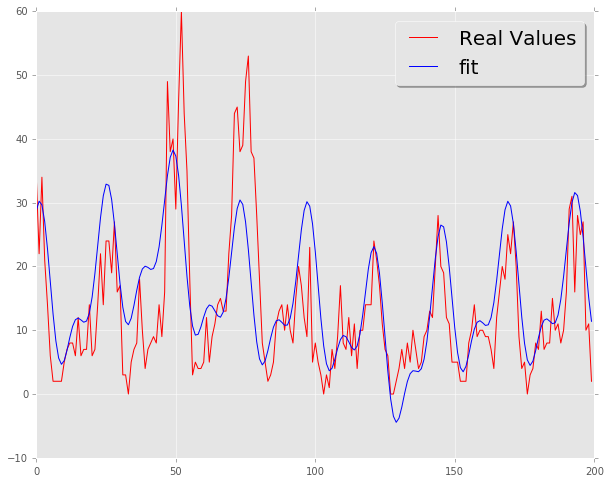

In [13]:
# plot the real data versus the fit in a zoomed in view
endind = 200
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(hour_after_start[0:endind], nlogins[0:endind], 'r', label = 'Real Values')
ax.plot(xx[0:endind], yy[0:endind] , color='b', label = 'fit')
ax.legend(shadow = True, fancybox = True, fontsize=20, loc=0)

#here we see that, while there is some discrepancy between fit and data, we are capturing the dominant periodicities.

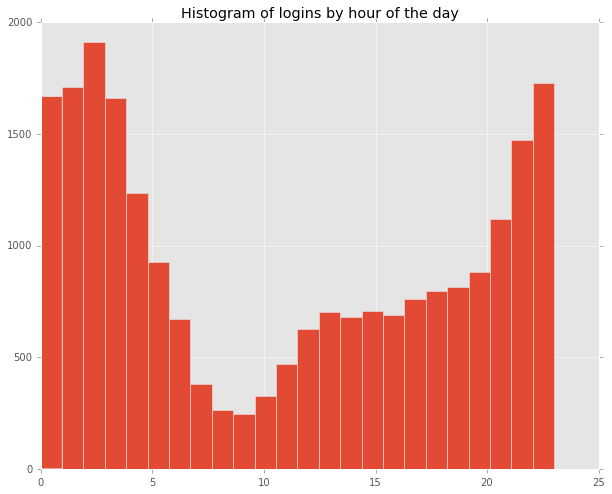

In [14]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
hodhist = ax.hist(data.hour_of_day, bins=24) #this plot shows the variation by hour of day
ax.set_title('Histogram of logins by hour of the day')
#here we see again the overall dual periodicity in the daily data (12 and 24 hour periods)

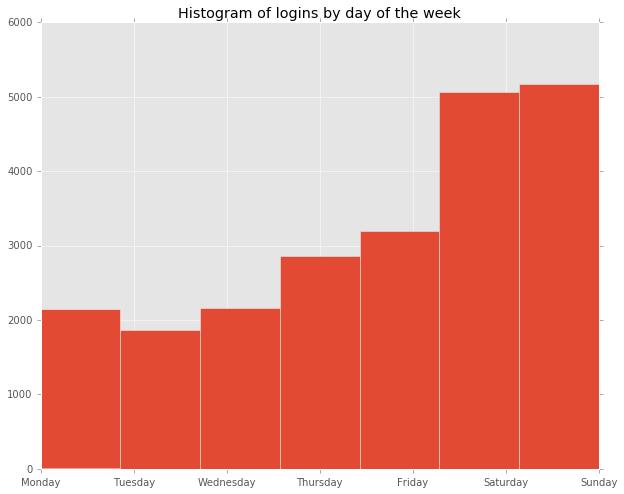

In [15]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
dowhist = ax.hist(data.day_of_week, bins=7) #this plot shows the variation by day of the week
dow_labels = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday','Sunday']
ax.set_xticklabels(dow_labels)
ax.set_title('Histogram of logins by day of the week')
#here we note the steady rise in demand throughout the week.